## Ejercicio (https://we.tl/t-ieOfdhsSTS)
Se parte de una señal analogica, la cual contiene información binaria modulada en BPSK y upsampleada a 10KHz. La Tasa de bits es de 2kbit/s, por lo tanto la máxima frecuencia presente en la señal es igual a 12KHz.

Para simular una señal analogica en un mundo digital se utiliza una frecuencia de muestreo de 40KHz.

## Importamos las librerias necesarias

In [ ]:
#!pip install scikit-dsp-comm

In [1]:
from sk_dsp_comm import digitalcom as dc
from sk_dsp_comm import sigsys as ss
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq
from scipy.signal import butter, lfilter
from scipy.signal import kaiserord, firwin, freqz
from scipy import signal
%matplotlib notebook

## Funciones de ayuda

In [2]:
# Funcion para graficar el diagrama de una señal
# Parametros:
# signal: Señal
# Ns:     Numero de muestras por bit
def Plot_Eye_Diagram(signal, Ns):
    L = Ns*2        # display length in samples (usually two symbols)
    S = 0           # start index
    percent = 0.01  # Porcentaje de la señal a mostrar en el diagrama ojo (para usar menos recursos)
    length = len(signal)
    ymin = int((length/Ns)*(0.5-percent))
    ymax = int((length/Ns)*(0.5+percent))
    dc.eye_plot(signal[Ns*ymin:Ns*ymax],L,S)  # Para mayor velocidad solo grafico un intervalo de 1000 simbolos
    plt.show()

In [3]:
# Funcion para graficar la fft de una señal
# Parametros:
# signal: Señal
# fs:     Frecuencia de muestreo
# xlim1:  Frecuencia minima a graficar
# xlim2:  Frecuencia maxima a graficar
# ylim1:  Amplitud minima a graficar
# ylim2:  Amplitud maxima a graficar
def Plot_FFT(signal,fs,xlim1=None,xlim2=None,ylim1=-100,ylim2=0):
    if xlim1==None:
        xlim1=-fs/2
    if xlim2==None:
        xlim2=fs/2
    plt.figure()
    N = signal.shape[0]
    Y = fft(signal)/N
    frq = fftfreq(N, 1/fs)
    plt.plot(frq, 20*np.log10(abs(Y)))
    plt.xlim(xlim1,xlim2)
    plt.ylim(ylim1,ylim2)
    plt.show()

In [4]:
# Generate_impulses: Genera un tren de impulsos en el dominio del tiempo
# Parametros de entrada:
# cnt_samples: cantidad de muestras a generar
# fs:          frecuencia de muestreo de la señal analogica
# fs_adc:      frecuencia del tren de impulsos
def Generate_impulses(cnt_samples, fs, fs_adc):
    x = np.zeros(cnt_samples)
    x[0::int(fs/fs_adc)]= 1
    return x

In [5]:
# Filtro pasa bajos
# Parametros:
# signal: Señal
# flow:   frecuencia de corte
# fs:     frecuencia de muestreo
def LowPassFilter(signal, flow, fs):
    nyq = fs/2
    low = flow / nyq
    order = 5
    b, a = butter(order, low, btype='low')
    y = lfilter(b, a, signal)
    return y

In [6]:
# Filtro pasa banda
# Parametros:
# signal: Señal
# flow:   frecuencia de corte inferior
# fhigh:  frecuencia de corte superior
# fs:     frecuencia de muestreo
def BandPassFilter(signal, flow, fhigh, fs):
    nyq = fs/2
    low = flow / nyq
    high = fhigh / nyq
    order = 5
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, signal)
    return y

In [7]:
# Funcion para decodificar la señal y mostrar el resultad
# Parametros:
# signal:      Señal
# eye_center:  Centro del ojo, lugar donde se debe muestrear
# Ns:          Numero de muestras por bit
def Demodulation_decoding(signal, eye_center, Ns):
    # Muestreado
    ys = signal[eye_center::Ns]

    # Umbralizado
    RxData = 1*(ys > 0)

    # Decodificacion
    Desfasaje = 6
    Aux_RxData = np.array(RxData[Desfasaje:].tolist() + np.zeros(Desfasaje,dtype=int).tolist(), dtype=np.uint8)
    RxData_pack = np.packbits(Aux_RxData)
    RxImg = RxData_pack.reshape((192, 262))
    plt.figure()
    plt.imshow(RxImg/255, cmap='gray')

## Carga de la señal

<IPython.core.display.Javascript object>


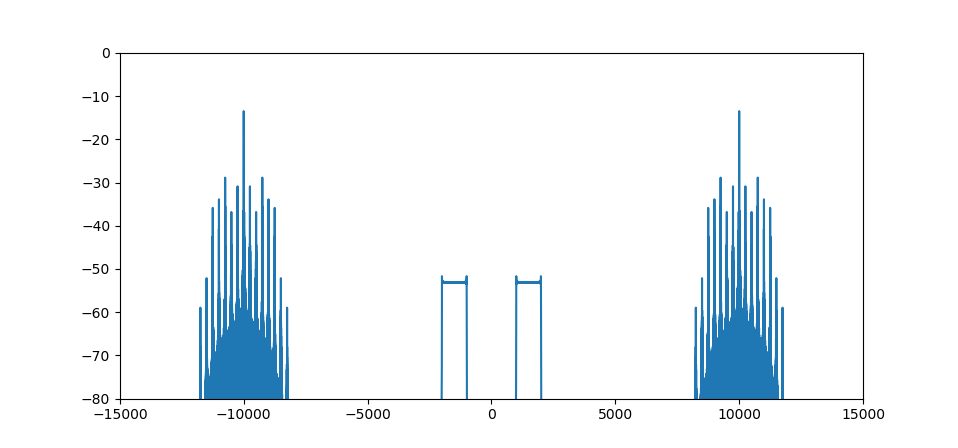

In [8]:
# Parametros
fs = 40000               # Frecuencia de muestreo señal analogica [Hz]
Tbit = 0.0005            # Tiempo del bit [sec]
Fc=10000                 # [Hz] frecuencia de la portadora
Ns = int(fs*Tbit)

st = np.load('Señal_Modulada.npy')
t = np.arange(len(st))*(1/fs)

## FFT de la Señal
Plot_FFT(st, fs, xlim1=-15000, xlim2=15000,ylim1=-80,ylim2=0)

## Muestreo y downsampling de la señal
Se debe realizar un downsampling y un muestreo de la señal analogica para recuperar la señal en banda base.

Se tiene dos restricciones:
* Dada la calidad del ADC, la frecuencia de muestreo debe ser menor a 15KHz
* No se cuenta con un bloque que realice el proceso de downsamplig a nivel analogico. (Tip: Aprovechar el aliasing del proceso de muestreo)

<IPython.core.display.Javascript object>


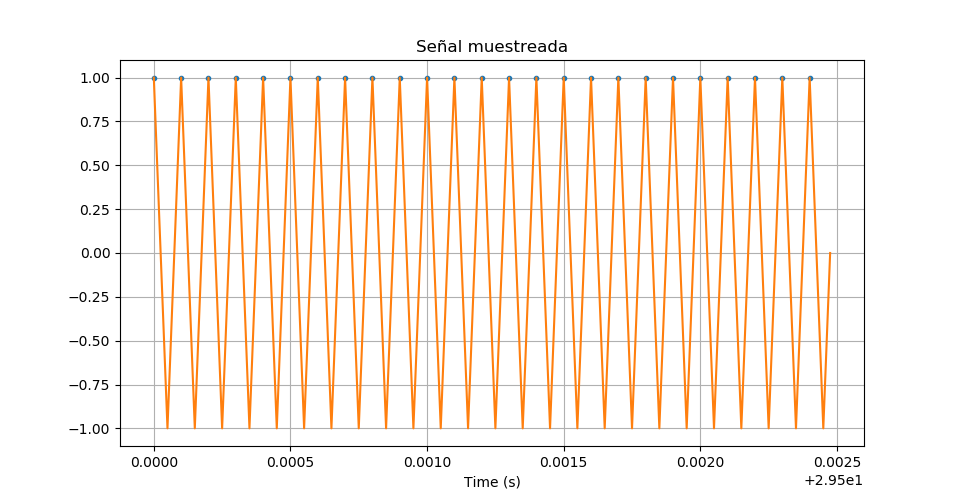

<IPython.core.display.Javascript object>


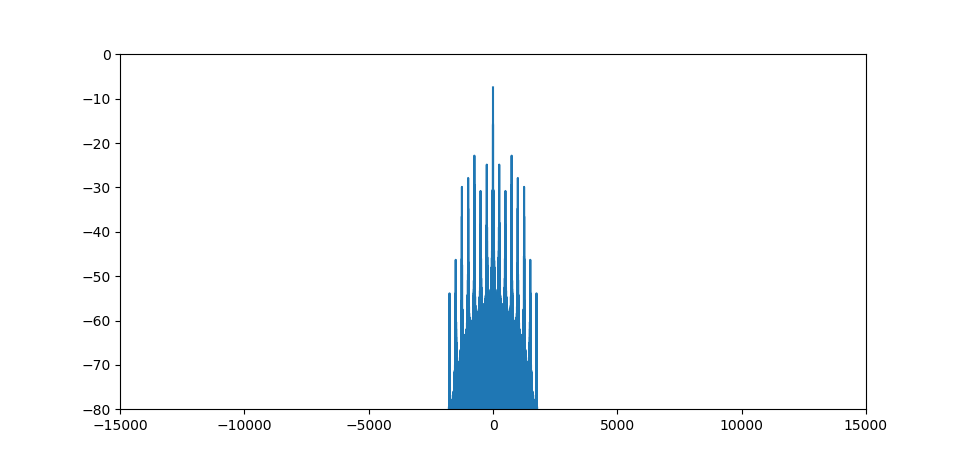

In [10]:
# 1. Acondicionar la señal para poder muestrearla de manera correcta
st_filtrada = BandPassFilter(st, 8000, 12000, 40000)

# 2. Generar la señal de muestreo
fs_adc = 10e3 # Frecuencia de muestreo del conversor ADC
SeñalDeMuestreo = Generate_impulses(len(st_filtrada), 40000, fs_adc)

# 3. Muestrear la señal utilizando la señal generada anteriormente
Señal_muestreada = st_filtrada[SeñalDeMuestreo>0]
n = np.arange(len(Señal_muestreada))*(1/fs_adc)

plt.figure()
limplot1 = int((Ns*59000)*(fs_adc/fs))
limplot2 = int((Ns*59005)*(fs_adc/fs))
plt.plot(n[limplot1:limplot2], Señal_muestreada[limplot1:limplot2],'.')
plt.plot(t[Ns*59000:Ns*59005], st_filtrada[Ns*59000:Ns*59005])
plt.title("Señal muestreada")
plt.xlabel('Time (s)')
plt.grid()
plt.show()

# 4. Representar la señal muestreada en el dominio de la frecuencia
Plot_FFT(Señal_muestreada, fs_adc, xlim1=-15000, xlim2=15000,ylim1=-80,ylim2=0)

## Filtrado

In [12]:
# 5. Aplicar un filtro pasa bajos a la señal, con una frecuencia de corte adecuada
Señal_filtrada = LowPassFilter(Señal_muestreada, 3000, fs_adc)

<IPython.core.display.Javascript object>


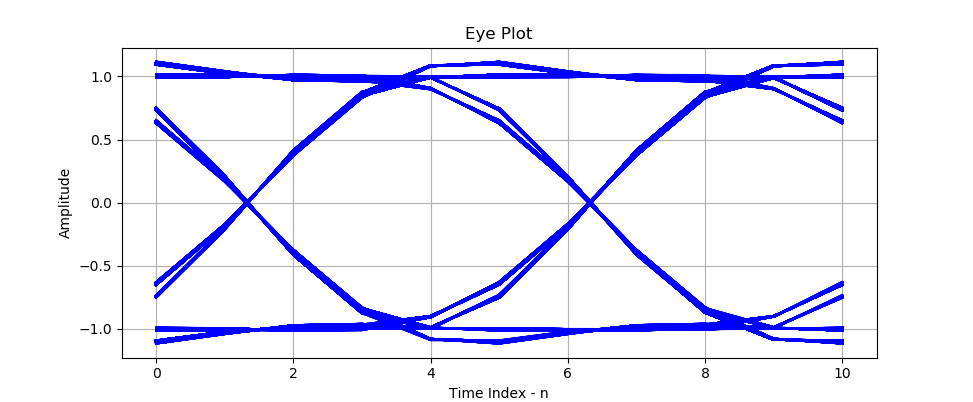

<IPython.core.display.Javascript object>


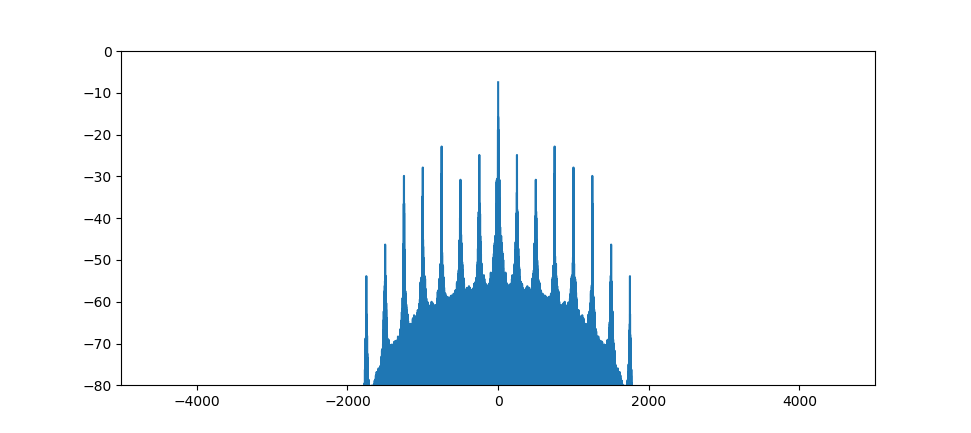

In [13]:
Plot_Eye_Diagram(Señal_filtrada, int(Ns*(fs_adc/fs)))
Plot_FFT(Señal_filtrada, fs_adc, xlim1=-5000, xlim2=5000,ylim1=-80,ylim2=0)

## Demodulacion y decodificación
Se debe obtener una imagen muy familiar en blanco y negro.

<IPython.core.display.Javascript object>


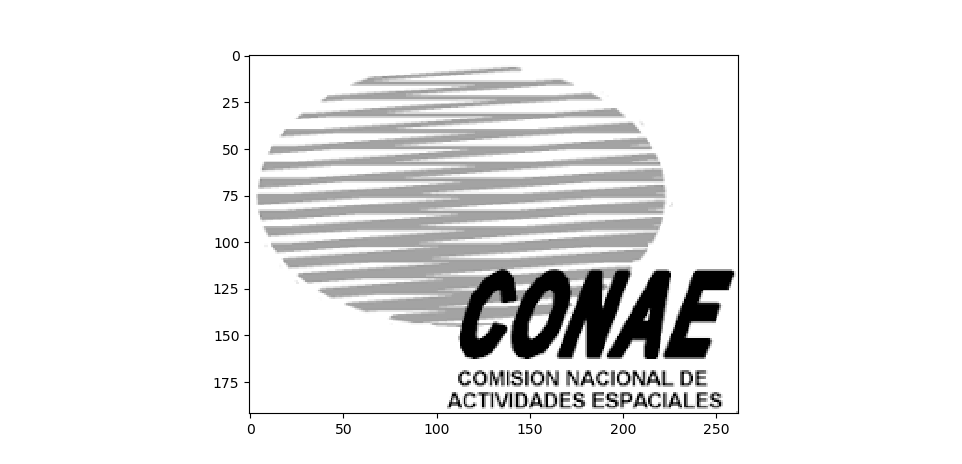

In [14]:
Eye_center = 3    # 6. Hayar el centro del ojo, el momento mas adecuado para muestrear y recuperar la informacion de la bpsk
Demodulation_decoding(Señal_filtrada, Eye_center, int(Ns*(fs_adc/fs)))  